# Resampling Methods



Resampling methods are an indispensable tool in modern statistics. They
involve repeatedly drawing samples from a training set and refitting a model
of interest on each sample in order to obtain additional information about
the fitted model. For example, in order to estimate the variability of a linear
regression fit, we can repeatedly draw different samples from the training
data, fit a linear regression to each new sample, and then examine the
extent to which the resulting fits differ. Such an approach may allow us to
obtain information that would not be available from fitting the model only
once using the original training sample.

In this chapter, we discuss two of the most commonly
used resampling methods, *cross-validation* and the *bootstrap*.

Cross-validation is most often used to estimate test error associated with a statistical learning method, whereas the bootstrap is most commonly used to provide a measure of accuracy for a given parameter/method.

The process
of evaluating a model's performance is known as *model assessment*, whereas 
the process of selecting the proper level of flexibility for a model is known as *model selection*.

## Setup

Import the necessary libraries:

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from ISLP import load_data
from sklearn.model_selection import train_test_split, KFold, ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

import pandas as pd
# Set plot style
sns.set_theme(style='whitegrid')
%matplotlib inline

## Cross Validation

Sometimes we want to estimate the test error rate using the available training data.
A number of approaches can be used for this.
In this section we consider methods which involve *holding out* a subset of the training data from the fitting process, then applying the model to that hold-out set for model assessment.

### The Validation Set Approach

This simple strategy involves randomly dividing available observations into training and validation sets.
The model is fit on the training set, and used to make predictions on the validation set.
The corresponding metric from the validation set predictions -- usually MSE in the case of a quantitative response -- provides an estimate of the test error rate.

Load the `Auto` data set:

In [2]:
# Load the Auto dataset
Auto = load_data('Auto')
Auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,15.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,18.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,16.0,8,304.0,150,3433,12.0,70,1
ford torino,17.0,8,302.0,140,3449,10.5,70,1


Randomly split the data into 50% training and 50% validation, fit on the training set, and compute the MSE on the validation set.
We'll repeat this 10 times to reproduce a figure similar to Figure 5.2.

In [3]:
def evaluate_poly_models(X_train, X_test, y_train, y_test, max_degree=10):
    """Evaluate polynomial models of different degrees."""
    mse_values = []
    for degree in range(1, max_degree + 1):
        # Create polynomial features
        poly_features = PolynomialFeatures(degree=degree, include_bias=False)
        X_train_poly = poly_features.fit_transform(X_train.reshape(-1, 1))
        X_test_poly = poly_features.transform(X_test.reshape(-1, 1))
        
        # Fit linear regression
        model = LinearRegression()
        model.fit(X_train_poly, y_train)
        
        # Predict and calculate MSE
        y_pred = model.predict(X_test_poly)
        mse = mean_squared_error(y_test, y_pred)
        mse_values.append(mse)
    
    return mse_values

# Set seed for reproducibility
np.random.seed(10)

# Prepare data
X = Auto['horsepower'].values
y = Auto['mpg'].values

# Single split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=10)
mse_single = evaluate_poly_models(X_train, X_test, y_train, y_test)

print("MSE for different polynomial degrees (single split):")
for i, mse in enumerate(mse_single[:3], 1):
    print(f"Degree {i}: {mse:.2f}")

MSE for different polynomial degrees (single split):
Degree 1: 23.06
Degree 2: 19.72
Degree 3: 19.71


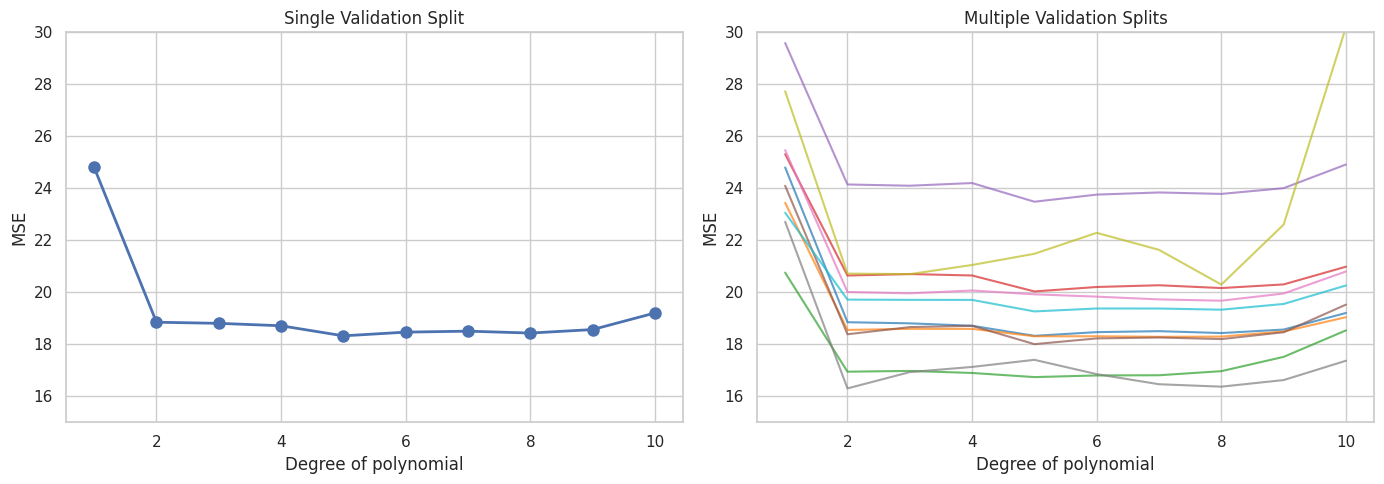

In [4]:
# Repeat validation split approach 10 times
all_mse = {}
for i in range(1, 11):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=i)
    mse_values = evaluate_poly_models(X_train, X_test, y_train, y_test)
    all_mse[i] = mse_values

# Plot results (similar to Figure 5.2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: single split
degrees = range(1, 11)
ax1.plot(degrees, all_mse[1], marker='o', linewidth=2, markersize=8)
ax1.set_xlabel('Degree of polynomial')
ax1.set_ylabel('MSE')
ax1.set_ylim([15, 30])
ax1.set_title('Single Validation Split')
ax1.grid(True)

# Right panel: multiple splits
colors = plt.cm.tab10(np.linspace(0, 1, 10))
for i, color in enumerate(all_mse.keys(), 1):
    ax2.plot(degrees, all_mse[i], linewidth=1.5, alpha=0.7, color=colors[i-1])
ax2.set_xlabel('Degree of polynomial')
ax2.set_ylabel('MSE')
ax2.set_ylim([15, 30])
ax2.set_title('Multiple Validation Splits')
ax2.grid(True)

plt.tight_layout()
plt.show()

As is clear from the right-hand panel, this approach is highly variable depending on the testing/validation set split.
Another downside is that, because the training set used to fit the data has fewer observations, it tends to overestimate the test error rate on the entire data set.

### Leave-One-Out Cross Validation (LOOCV)

*Leave-one-out cross validation* (LOOCV) attempts to address the shortcomings of the validation set approach.
It still involves splitting the $n$ observations into two parts, but it repeats it $n$ times, with a single observation $(x_i, y_i)$ as the hold-out "set" and the remaining $n-1$ observations as the training set.
The MSE for each iteration is simply $\text{MSE}_i = (y_i - \hat{y}_i)^2$.
Then the LOOCV estimate of the MSE is the average over all observations:

$$
\text{CV}_{(n)} = \frac{1}{n} \sum_{i=1}^n \text{MSE}_i.
$$

The LOOCV approach has advantages over the validation set approach:
- First, it has far less bias since we use training sets with $n - 1$ observations.
- Second, it yields deterministic results (no randomness in splits).

In [5]:
# LOOCV for polynomial regression
from sklearn.model_selection import LeaveOneOut

def loocv_mse(X, y, degree):
    """Calculate LOOCV MSE for a polynomial model."""
    loo = LeaveOneOut()
    mse_scores = []
    
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly_features.fit_transform(X.reshape(-1, 1))
    
    for train_idx, test_idx in loo.split(X_poly):
        X_train, X_test = X_poly[train_idx], X_poly[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse_scores.append((y_test[0] - y_pred[0])**2)
    
    return np.mean(mse_scores)

# Calculate LOOCV MSE for degrees 1-10
# Note: This can be slow for large datasets
print("Computing LOOCV MSE (this may take a moment)...")
loocv_mse_values = [loocv_mse(X, y, degree) for degree in range(1, 11)]

print("\nLOOCV MSE for different polynomial degrees:")
for i, mse in enumerate(loocv_mse_values, 1):
    print(f"Degree {i}: {mse:.2f}")

Computing LOOCV MSE (this may take a moment)...

LOOCV MSE for different polynomial degrees:
Degree 1: 24.23
Degree 2: 19.25
Degree 3: 19.33
Degree 4: 19.42
Degree 5: 19.03
Degree 6: 19.17
Degree 7: 19.13
Degree 8: 19.01
Degree 9: 19.17
Degree 10: 19.91

LOOCV MSE for different polynomial degrees:
Degree 1: 24.23
Degree 2: 19.25
Degree 3: 19.33
Degree 4: 19.42
Degree 5: 19.03
Degree 6: 19.17
Degree 7: 19.13
Degree 8: 19.01
Degree 9: 19.17
Degree 10: 19.91


### $k$-fold Cross-Validation

*$k$-fold CV* involves randomly dividing the observations into $k$ groups/folds of approximately equal size.
The first fold is used as the validation/assessment set, and the remaining $k-1$ folds used to fit the model.
This is repeated $k$ times, with each fold being used as the assessment set once.
The $k$-fold CV estimate of the test error is then the average:

$$
\text{CV}_{(k)} = \frac{1}{k} \sum_{i=1}^k \text{MSE}_i.
$$

LOOCV is a special case of $k$-fold CV where $k = n$. In practice, one typically performs $k$-fold CV using $k$ = 5
or $k$ = 10. The advantage is computational: LOOCV requires fitting the model $n$ times, while 10-fold
CV requires only ten fits.

In [6]:
# 10-fold cross-validation
def kfold_cv_mse(X, y, degree, k=10, random_state=10):
    """Calculate k-fold CV MSE for a polynomial model."""
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    mse_scores = []
    
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly_features.fit_transform(X.reshape(-1, 1))
    
    for train_idx, test_idx in kf.split(X_poly):
        X_train, X_test = X_poly[train_idx], X_poly[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse_scores.append(mean_squared_error(y_test, y_pred))
    
    return np.mean(mse_scores)

# Calculate 10-fold CV MSE for degrees 1-10
kfold_mse_values = [kfold_cv_mse(X, y, degree) for degree in range(1, 11)]

print("10-fold CV MSE for different polynomial degrees:")
for i, mse in enumerate(kfold_mse_values, 1):
    print(f"Degree {i}: {mse:.2f}")

10-fold CV MSE for different polynomial degrees:
Degree 1: 24.13
Degree 2: 19.29
Degree 3: 19.42
Degree 4: 19.48
Degree 5: 19.06
Degree 6: 19.18
Degree 7: 19.14
Degree 8: 19.05
Degree 9: 19.23
Degree 10: 19.98


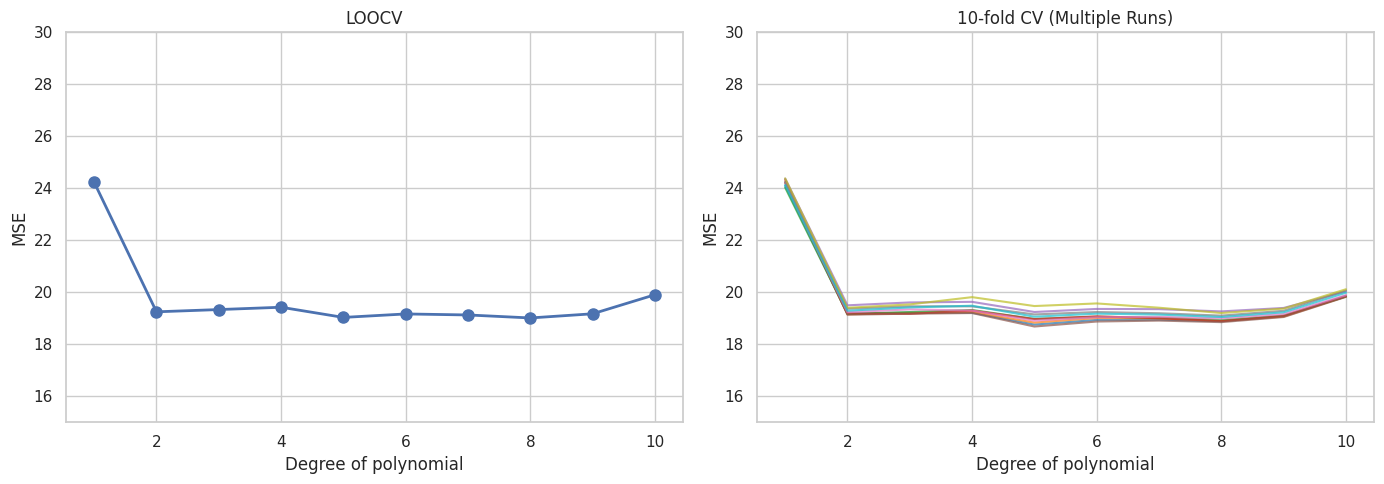

In [7]:
# Repeat 10-fold CV with different random seeds and plot
all_kfold_mse = {}
for seed in range(1, 11):
    mse_values = [kfold_cv_mse(X, y, degree, random_state=seed) for degree in range(1, 11)]
    all_kfold_mse[seed] = mse_values

# Plot results (similar to Figure 5.4)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: LOOCV (deterministic)
degrees = range(1, 11)
ax1.plot(degrees, loocv_mse_values, marker='o', linewidth=2, markersize=8)
ax1.set_xlabel('Degree of polynomial')
ax1.set_ylabel('MSE')
ax1.set_ylim([15, 30])
ax1.set_title('LOOCV')
ax1.grid(True)

# Right panel: 10-fold CV (multiple runs)
degrees = range(1, 11)
colors = plt.cm.tab10(np.linspace(0, 1, 10))
for i, color in enumerate(all_kfold_mse.keys(), 1):
    ax2.plot(degrees, all_kfold_mse[i], linewidth=1.5, alpha=0.7, color=colors[i-1])
ax2.set_xlabel('Degree of polynomial')
ax2.set_ylabel('MSE')
ax2.set_ylim([15, 30])
ax2.set_title('10-fold CV (Multiple Runs)')
ax2.grid(True)

plt.tight_layout()
plt.show()

The $k$-fold CV approach (right panel) still has some variability due to random splitting, but much less than the validation set approach.

## The Bootstrap

The *bootstrap* is a widely applicable and extremely powerful statistical tool that can be used to quantify the uncertainty associated with a given estimator or statistical learning method. As a simple example, the bootstrap can be used to estimate the standard errors of the coefficients from a linear regression fit.

The toy example in this section is about investment in two assets $X$ and $Y$.
We wish to choose a fraction $\alpha$ of investment into $X$ which minimizes the total variance (risk) of the investment.
It can be shown that the optimal value is given by:

$$
\alpha = \frac{\sigma_Y^2 - \sigma_{XY}}{\sigma_X^2 + \sigma_Y^2 - 2\sigma_{XY}},
$$

where $\sigma_X^2 = \text{Var}(X)$, $\sigma_Y^2 = \text{Var}(Y)$, and $\sigma_{XY} = \text{Cov}(X, Y)$.

In reality, we don't know these variances and covariance, so we estimate them (e.g. $\hat{\sigma}_X^2$) using observations of $X$ and $Y$ to get an estimated $\hat{\alpha}$.

In [25]:
# Load Portfolio data
Portfolio = load_data('Portfolio')
Portfolio.head()

,X,Y
0,-0.895251,-0.234924
1,-1.562454,-0.885176
2,-0.417090,0.271888
3,1.044356,-0.734198
4,-0.315568,0.841983


Write a function to compute $\alpha$ from the simulated $X$ and $Y$:

In [35]:
# Function to compute alpha
def alpha_func(X, Y):
    """Compute the optimal alpha for range specified"""
    return ((np.var(Y) - np.cov(X, Y)[0, 1]) / 
            (np.var(X) + np.var(Y) - 2 * np.cov(X, Y)[0, 1]))

# Compute alpha from the full dataset
alpha_hat = alpha_func(Portfolio['X'], Portfolio['Y'])
print(f"Estimated alpha of entire portfolio: {alpha_hat:.3f}")

Estimated alpha of entire portfolio: 0.577


Run four simulations of n=1000 and plot $X$ vs $Y$

Bootstrap mean of alpha: 0.582
Bootstrap SE of alpha: 0.093


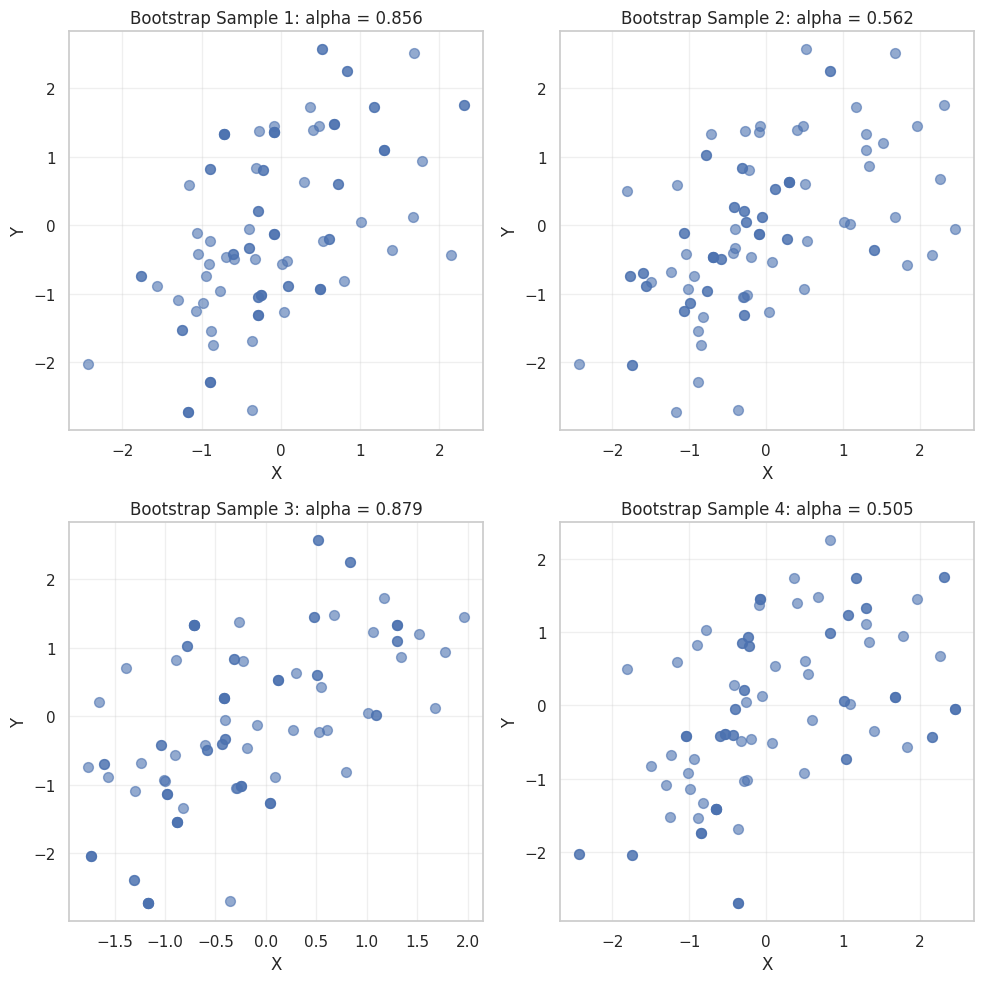


Four bootstrap resamples showing variability in alpha estimates


In [36]:
# Bootstrap to estimate standard error of alpha
def bootstrap_alpha(data, n_bootstrap=1000, random_state=319):
    """Perform bootstrap resampling to estimate SE of alpha."""
    np.random.seed(random_state)
    n = len(data)
    alpha_estimates = []
    
    for _ in range(n_bootstrap):
        # Resample with replacement
        idx = np.random.choice(n, size=n, replace=True)
        X_boot = data['X'].iloc[idx]
        Y_boot = data['Y'].iloc[idx]
        alpha_estimates.append(alpha_func(X_boot, Y_boot))
    
    return np.array(alpha_estimates)

# Perform bootstrap
alpha_boot = bootstrap_alpha(Portfolio, n_bootstrap=1000)

print(f"Bootstrap mean of alpha: {np.mean(alpha_boot):.3f}")
print(f"Bootstrap SE of alpha: {np.std(alpha_boot):.3f}")

# Visualize 4 different bootstrap samples
np.random.seed(319)
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

bootstrap_samples = []
for i in range(4):
    # Resample with replacement
    idx = np.random.choice(len(Portfolio), size=len(Portfolio), replace=True)
    X_boot = Portfolio['X'].iloc[idx]
    Y_boot = Portfolio['Y'].iloc[idx]
    alpha_sample = alpha_func(X_boot, Y_boot)
    bootstrap_samples.append((X_boot, Y_boot, alpha_sample))
    
    # Plot
    axes[i].scatter(X_boot, Y_boot, alpha=0.6, s=50)
    axes[i].set_xlabel('X')
    axes[i].set_ylabel('Y')
    axes[i].set_title(f'Bootstrap Sample {i+1}: alpha = {alpha_sample:.3f}')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

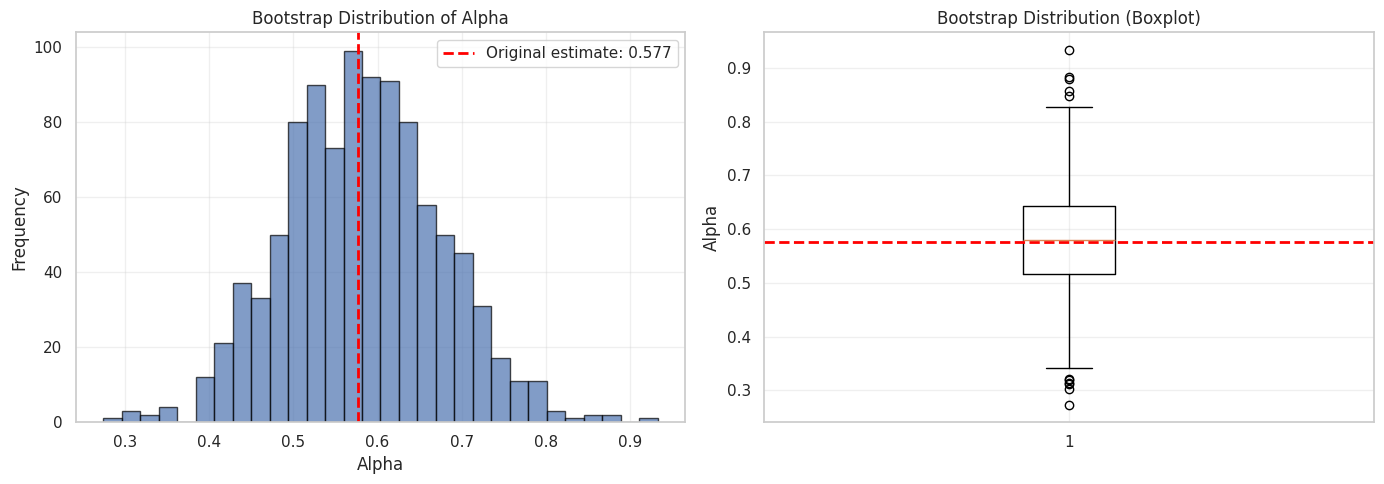

In [28]:
# Visualize bootstrap distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1.hist(alpha_boot, bins=30, edgecolor='black', alpha=0.7)
ax1.axvline(alpha_hat, color='red', linestyle='--', linewidth=2, label=f'Original estimate: {alpha_hat:.3f}')
ax1.set_xlabel('Alpha')
ax1.set_ylabel('Frequency')
ax1.set_title('Bootstrap Distribution of Alpha')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Boxplot
ax2.boxplot(alpha_boot, vert=True)
ax2.axhline(alpha_hat, color='red', linestyle='--', linewidth=2)
ax2.set_ylabel('Alpha')
ax2.set_title('Bootstrap Distribution (Boxplot)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Note that the histogram looks very idealized. In particular the
bootstrap estimate $\text{SE}(\hat{\alpha})$ from (5.8) is 0.087, very close to the estimate
of 0.083 obtained using 1,000 simulated data sets.  The
boxplots have similar spreads, indicating that the bootstrap approach can
be used to effectively estimate the variability associated with $\hat{\alpha}$.

### Estimating the Accuracy of a Linear Regression Model

The bootstrap approach can be used to assess the variability of the coefficient estimates from a statistical learning method. Here we use the bootstrap to assess the variability of the estimates for $\beta_0$ and $\beta_1$, the intercept and slope terms for the linear regression model that uses horsepower to predict mpg in the `Auto` data set.

To save time we will use `linearRegression()` from `sklearn` to fit a model regressing Horsepower on mpg. We can extract performance metrics from this sklearn model object.

In [49]:

X_auto_hp = Auto[['horsepower']]
y_auto_mpg = Auto['mpg']

model = LinearRegression()
model.fit(X_auto_hp, y_auto_mpg)

print(f"Intercept: {model.intercept_:.4f}")
print(f"Coefficient: {model.coef_[0]:.4f}")

Intercept: 39.9359
Coefficient: -0.1578


We then write a function to compute the standard errors (SE) of linear regression coefficients.

1. **Initialize**: Set random seed and create empty lists for storing results
2. **Loop**: Repeat `n_bootstrap` times (1000 times):
   - Randomly sample `n` indices **with replacement** from the data
   - Extract bootstrap samples: `X_boot` and `y_boot`
   - Fit a linear regression model to the bootstrap sample
   - Store the intercept and coefficient from this model
3. **Return**: Convert lists to numpy arrays and return both arrays

In [30]:
# Bootstrap for regression coefficients (boot_SE)
def bootstrap_regression(X, y, n_bootstrap=1000, random_state=42):
    """Perform bootstrap to estimate SE of regression coefficients."""
    np.random.seed(random_state)
    n = len(X)
    intercepts = []
    coefs = []
    
    for _ in range(n_bootstrap):
        idx = np.random.choice(n, size=n, replace=True)
        X_boot = X.iloc[idx]
        y_boot = y.iloc[idx]
        
        model_boot = LinearRegression()
        model_boot.fit(X_boot, y_boot)
        
        intercepts.append(model_boot.intercept_)
        coefs.append(model_boot.coef_[0])
    
    return np.array(intercepts), np.array(coefs)

# Perform bootstrap
boot_intercepts, boot_coefs = bootstrap_regression(X_auto_hp, y_auto_mpg)

print("Bootstrap estimates:")
print(f"Intercept - Mean: {np.mean(boot_intercepts):.4f}, SE: {np.std(boot_intercepts):.4f}")
print(f"Coefficient - Mean: {np.mean(boot_coefs):.4f}, SE: {np.std(boot_coefs):.4f}")

Bootstrap estimates:
Intercept - Mean: 39.9694, SE: 0.8687
Coefficient - Mean: -0.1583, SE: 0.0075


### Quadratic Model Bootstrap

We can find better correspondence between bootstrap and regression estimates if we use the quadratic model because it better fits the data:

In [37]:
# Bootstrap for quadratic regression
def bootstrap_quad_regression(X, y, n_bootstrap=1000, random_state=42):
    """Perform bootstrap for quadratic regression."""
    np.random.seed(random_state)
    n = len(X)
    coef_results = []
    
    for _ in range(n_bootstrap):
        idx = np.random.choice(n, size=n, replace=True)
        X_boot = X.iloc[idx]
        y_boot = y.iloc[idx]
        
        # Create quadratic features
        poly = PolynomialFeatures(degree=2, include_bias=True)
        X_boot_poly = poly.fit_transform(X_boot)
        
        model_boot = LinearRegression(fit_intercept=False)
        model_boot.fit(X_boot_poly, y_boot)
        
        coef_results.append(model_boot.coef_)
    
    return np.array(coef_results)

# Perform bootstrap for quadratic model
boot_quad_coefs = bootstrap_quad_regression(X_auto, y_auto)

print("Bootstrap estimates for quadratic model:")
print(f"Intercept - Mean: {np.mean(boot_quad_coefs[:, 0]):.4f}, SE: {np.std(boot_quad_coefs[:, 0]):.4f}")
print(f"Linear term - Mean: {np.mean(boot_quad_coefs[:, 1]):.4f}, SE: {np.std(boot_quad_coefs[:, 1]):.4f}")
print(f"Quadratic term - Mean: {np.mean(boot_quad_coefs[:, 2]):.4f}, SE: {np.std(boot_quad_coefs[:, 2]):.4f}")

Bootstrap estimates for quadratic model:
Intercept - Mean: 56.9720, SE: 2.1186
Linear term - Mean: -0.4678, SE: 0.0337
Quadratic term - Mean: 0.0012, SE: 0.0001


## Permutation
The permutation test is a **nonparametric hypothesis test** for:
$$H_0: F_A = F_B \quad \text{vs.} \quad H_1: F_A \neq F_B$$

Under $H_0$, the cell type labels are arbitrary—the null distribution of the test statistic $T = \bar{Y}_B - \bar{Y}_A$ is generated by randomly reassigning labels to the pooled data.

**Key insight**: The p-value represents the probability of observing a difference as extreme (or more extreme) than $\hat{\Delta}$ if the null hypothesis were true:

$$p\text{-value} = P(|T^*| \geq |\hat{\Delta}| \mid H_0)$$

where $T^*$ is drawn from the empirical null distribution constructed via permutations. This avoids parametric assumptions about the underlying distributions.


Here we simulate a Differential Gene Expression experiment and do a permutation test.
- Generate two synthetic gamma-distributed expression samples (sizes 50 and 45) and compute their observed mean difference:  $\hat{\Delta} = \bar{Y}_B - \bar{Y}_A$
- Perform 10 000 label permutations, recording the mean difference for each shuffled assignment.  
- Visualize observed data, a few permuted differences, and the null distribution, then print a textual statistical summary (sample sizes, means, observed difference, p-value).

In [52]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate synthetic data
n_cells_A = 50
n_cells_B = 45

# Cell type A: lower expression (mean=2.5)
#
expression_A = np.random.gamma(shape=2, scale=1.25, size=n_cells_A)

# Cell type B: higher expression (mean=4.0)  
expression_B = np.random.gamma(shape=3, scale=1.33, size=n_cells_B)

# Combine data
all_expression = np.concatenate([expression_A, expression_B])
cell_types = ['Cell Type A'] * n_cells_A + ['Cell Type B'] * n_cells_B

# Calculate observed difference in means

observed_diff = np.mean(expression_B) - np.mean(expression_A)

print(f"Observed difference in means: {observed_diff:.4f}")

Observed difference in means: 1.4251


In [62]:
# Permutation test
n_permutations = 10000
permuted_diffs = []

for i in range(n_permutations):
    # Shuffle the cell type labels
    shuffled_labels = np.random.permutation(cell_types)
    
    # Calculate difference in means for shuffled data
    group_A_shuffled = all_expression[np.array(shuffled_labels) == 'Cell Type A']
    group_B_shuffled = all_expression[np.array(shuffled_labels) == 'Cell Type B']
    
    diff_shuffled = np.mean(group_B_shuffled) - np.mean(group_A_shuffled)
    permuted_diffs.append(diff_shuffled)

permuted_diffs = np.array(permuted_diffs)

# Calculate p-value
p_value = np.sum(np.abs(permuted_diffs) >= np.abs(observed_diff)) / n_permutations
print(f"two tailed P-value from permutation test: {p_value:.4f}")

two tailed P-value from permutation test: 0.0000


/tmp/ipykernel_6357/1813286596.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data_df, x='Cell_Type', y='Expression', ax=ax, palette=['lightcoral', 'skyblue'])


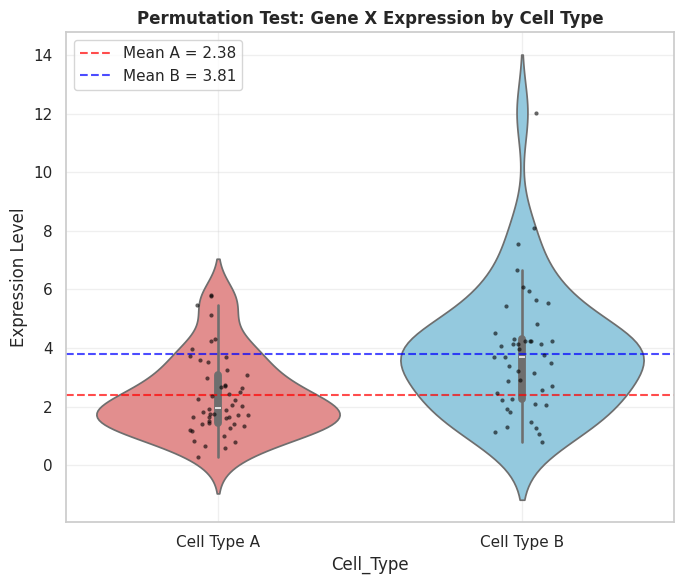

In [57]:
# Figure 1: Observed expression distribution
# data_df aggregates expression values with their cell type labels
data_df = pd.DataFrame({
    'Expression': all_expression,
    'Cell_Type': cell_types
})

# fig, ax = plt.subplots creates a figure and axes for the violin plot
fig, ax = plt.subplots(figsize=(7, 6))
sns.violinplot(data=data_df, x='Cell_Type', y='Expression', ax=ax, palette=['lightcoral', 'skyblue'])
sns.stripplot(data=data_df, x='Cell_Type', y='Expression', ax=ax, color='black', alpha=0.6, size=3)

# ax.axhline overlays group means for comparison
ax.axhline(np.mean(expression_A), color='red', linestyle='--', alpha=0.7, label=f"Mean A = {np.mean(expression_A):.2f}")
ax.axhline(np.mean(expression_B), color='blue', linestyle='--', alpha=0.7, label=f"Mean B = {np.mean(expression_B):.2f}")
ax.set_title('Permutation Test: Gene X Expression by Cell Type', fontweight='bold')
ax.set_ylabel('Expression Level')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()

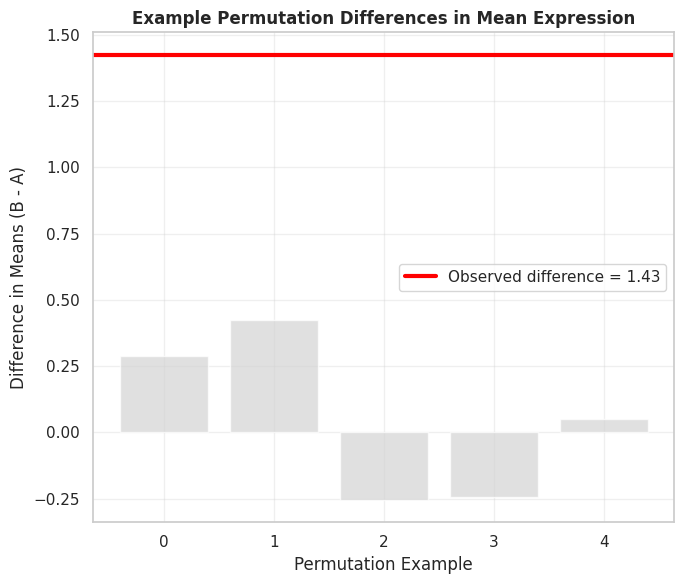

In [58]:
# Figure 2: Permutation differences examples
# n_examples controls the number of permutation differences displayed
n_examples = 5
# example_diffs slices the first permutation differences for illustration
example_diffs = permuted_diffs[:n_examples]

# fig, ax = plt.subplots prepares the bar chart canvas
fig, ax = plt.subplots(figsize=(7, 6))
ax.bar(range(n_examples), example_diffs, color='lightgray', alpha=0.7)
ax.axhline(observed_diff, color='red', linewidth=3, label=f"Observed difference = {observed_diff:.2f}")
ax.set_title('Example Permutation Differences in Mean Expression', fontweight='bold')
ax.set_xlabel('Permutation Example')
ax.set_ylabel('Difference in Means (B - A)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()

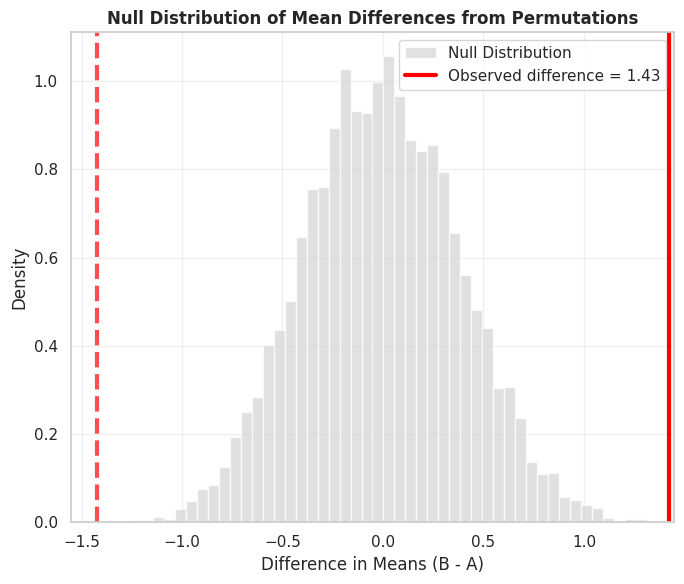

In [59]:
# Figure 3: Null distribution from permutations
# extreme_values identifies permutation differences at least as extreme as observed
extreme_values = permuted_diffs[np.abs(permuted_diffs) >= np.abs(observed_diff)]

# fig, ax = plt.subplots initializes the histogram canvas
fig, ax = plt.subplots(figsize=(7, 6))
ax.hist(permuted_diffs, bins=50, alpha=0.7, color='lightgray', density=True, label='Null Distribution')
ax.axvline(observed_diff, color='red', linewidth=3, label=f"Observed difference = {observed_diff:.2f}")
ax.axvline(-observed_diff, color='red', linewidth=3, linestyle='--', alpha=0.7)

# ax.hist with extreme_values highlights the two-tailed rejection region
if len(extreme_values) > 0:
    ax.hist(extreme_values, bins=20, alpha=0.8, color='red', density=True, label='p-value region')
ax.set_title('Null Distribution of Mean Differences from Permutations', fontweight='bold')
ax.set_xlabel('Difference in Means (B - A)')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()

In [61]:
summary_text = f"""
Statistical Summary:

• Sample sizes: n_A = {n_cells_A}, n_B = {n_cells_B}

• Observed means:
  Cell Type A: {np.mean(expression_A):.3f}
  Cell Type B: {np.mean(expression_B):.3f}

• Observed difference: {observed_diff:.3f}

• Permutations: {n_permutations:,}

• P-value: {p_value:.4f}

• Interpretation: 
  {'Reject H₀' if p_value < 0.05 else 'Fail to reject H₀'} 
  (α = 0.05)
"""
print(summary_text)


Statistical Summary:

• Sample sizes: n_A = 50, n_B = 45

• Observed means:
  Cell Type A: 2.380
  Cell Type B: 3.805

• Observed difference: 1.425

• Permutations: 10,000

• P-value: 0.0000

• Interpretation: 
  Reject H₀ 
  (α = 0.05)

